# Project: Furuta Pendulum

This notebook containts our report for the Furuta Pendulum Project - Group 003 - Flavio Proietti r0978464 & Giuseppe Galea Curmi r0966326

In [1]:
# Load the autoreload extension to automatically reload modules when they are modified
%load_ext autoreload

# Set autoreload to reload all modules before executing code
%autoreload 2

## 1 Model-based Control
## (a) Optimization-based Motion Planner for Swing-Up

This section outlines the design and implementation of an optimization-based motion planner that can swing the pendulum from the downward position to the upright position.

In [2]:
import os
import time
import yaml
import numpy as np
import casadi as ca
from rockit import *
from matplotlib import pyplot as plt
import pinocchio as pin
import pinocchio.casadi as cpin
from pinocchio.visualize import MeshcatVisualizer as PMV
import meshcat
import meshcat.transformations as tf
import gymnasium as gym
from src.envs.furuta_torque_env import FurutaPendulumTorqueEnv
import torch
from src.agents.ppo_continuous_action import Agent, make_env


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

After having imported all the required packages, the command **os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"** was inserted to solve some conflicts between the different packages. 

The following code has the role of importing the .yaml, the .urdf and the dynamics equations. These information are required to analyse the dynamic of the FURUTA PENDULUM in  the optimization problem.

In [3]:
with open('src/pendulum_model/pendulum_description/simulation_pendulum.yaml', 'r') as file:
        config = yaml.safe_load(file)

parameters_model = config["parameters_model"]
urdf_path = os.path.join("src/pendulum_model/pendulum_description", config["urdf_filename"])
forward_dynamics_casadi_path = os.path.join("src/pendulum_model/pendulum_description", config["forward_dynamics_casadi_filename"])

### OCP Definition

The optimal control problem (OCP) was then formulated with a **fixed time horizon** to ensure compatibility with the simulation environment. In preliminary tests, allowing the final time to be free led to time intervals that did not align with the fixed update rate of the simulation environment. This mismatch would have required interpolation of the control inputs to integrate with the reinforcement learning (RL) policy, introducing unnecessary complexity and potential inaccuracies.

To maintain consistency with the environment’s update rate, the problem was discretized using the **Multiple Shooting** method with \( N = 30 \) control intervals and \( M = 1 \) integration step per interval with a fixed time duration of 0.3s derived from the previously executed free time problems. This configuration ensured a time step of \( 0.01s \), which matches the control frequency of the simulation environment.

The integration method used within each interval was an explicit **Runge–Kutta** scheme (`rk`), which offers a good trade-off between computational efficiency and numerical accuracy for smooth, continuous dynamics. The choice of \( M = 1 \) allows for a minimal integration effort per interval while still respecting the short control timestep required by the simulation. This approach reduces solver overhead without compromising the fidelity of the integrated system dynamics.

### Model constraints

Initially, the code extracts the joint limitations from the `.yaml` file. These values are then used as constraints in the OCP, namely: `q_min`, `q_max`, `v_min`, `v_max`, `u_min`, and `u_max`.

Subsequently, the initial and desired final states were defined, denoted as `q_start` and `q_goal`.

The state and control variables of the OCP were then specified. The state consists of the angular positions and velocities of the two joints, while the control input corresponds to the torque applied at the first joint.


### Additional Constraints

Further constraints were imposed on the OCP to define boundary conditions and improve system behavior:

- `ocp.subject_to(ocp.at_t0(x) == q_start)`  
  → Constrains the initial state of the system to the specified starting position.

- `ocp.subject_to(ocp.at_t0(v) == 0)`  
  → Sets the initial velocity of the system to zero.

- `ocp.subject_to(ocp.at_t0(u[0]) == 0)`  
  → Ensures that the initial control input (torque) is zero.

- `ocp.subject_to(ocp.at_tf(x) == q_goal)`  
  → Constrains the final state to reach the desired goal configuration.

- `ocp.subject_to(ocp.at_tf(v[1]) == 0)`  
  → Forces the final velocity of the second joint (`theta₂`) to be zero, improving the stability of the final pendulum state and facilitating integration with the RL policy.



### Dynamics Integration

The system dynamics were incorporated using the pre-compiled CasADi function:

`forward_dynamics_raw = ca.Function.load(forward_dynamics_casadi_path)`

- `ocp.set_der(x, v)`  
  → Specifies that the time derivative of the position state `x` corresponds to the velocity `v`.

- `ocp.set_der(v, forward_dynamics_ca(x, v, u))`  
  → Defines the time derivative of the velocity state `v` as the system's acceleration, computed via the dynamics function generated using **Pinocchio**.

This setup ensures that the OCP accurately reflects the dynamics of the Furuta pendulum, enabling proper trajectory planning under physical constraints.



### Cost Function

The cost function was formulated as a **quadratic integral cost**, penalizing deviations of the second joint angle $\theta_2$ from its desired target value $\theta_2^{\text{goal}}$:

$$
J = \int_0^T 10 \cdot (\theta_2(t) - \theta_2^{\text{goal}})^2 \, dt
$$

### Solver

The problem was then solved using an `ipopt` solver, which is well-suited for nonlinear and non-convex optimization problems such as this one.


### Convexity Considerations

- **Cost function → Convex**
  - The objective is defined as a quadratic cost as shown above.  

  - This is convex because it penalizes the squared deviation from a target state, and squared terms are convex when the coefficient is positive.

- **State and control bounds → Convex**
  - Constraints such as `x ≥ q_min`, `x ≤ q_max`, and similar ones for `v` and `u` are linear inequalities.
  - Linear inequality constraints define convex feasible sets.

- **Initial and final conditions → Convex**
  - Conditions like `x(0) = q_start`, `x(T) = q_goal`, `v(0) = 0`, and `v[1](T) = 0` are affine equalities.
  - Equality constraints are convex if the expressions involved are affine.

- **System dynamics →  Not convex**
  - The dynamic model `v̇ = f(x, v, u)` is derived from the nonlinear equations of motion of the Furuta pendulum using Pinocchio.
  - These dynamics are nonlinear and non-affine in the state and control variables.
  - This violates the convexity condition that requires system dynamics to be affine.

**Conclusion**: While the objective and constraints are convex in isolation, the presence of nonlinear dynamics makes the **overall optimal control problem non-convex**.


In [4]:
T_fixed = 0.3
ocp = Ocp(T=T_fixed)
N = 30
M = 1

q_min = np.array([-parameters_model["max_angle_joint0"], -parameters_model["max_angle_joint1"]])
q_max = np.array([ parameters_model["max_angle_joint0"],  parameters_model["max_angle_joint1"]])

v_min = np.array([-parameters_model["max_velocity_joint0"], -0.5*parameters_model["max_velocity_joint1"]])
v_max = -v_min

u_min = np.array([-parameters_model["max_torque_joint0"], 0.0])  # only joint 0 actuated
u_max = -u_min

q_start = np.array([0,0])
q_goal = np.array([0.0, np.deg2rad(180)])


x = ocp.state(len(q_min))
v = ocp.state(len(q_min))
u = ocp.control(len(q_min))

ocp.subject_to(ocp.at_t0(x) == q_start)
ocp.subject_to(ocp.at_t0(v) == 0)
ocp.subject_to(ocp.at_t0(u[0]) == 0)
ocp.subject_to(ocp.at_tf(x) == q_goal)
ocp.subject_to(ocp.at_tf(v[1]) == 0)

# Dummy forward dynamics function for demonstration
forward_dynamics_raw = ca.Function.load(forward_dynamics_casadi_path)

def forward_dynamics_ca(q, dq, tau):
    return forward_dynamics_raw(q, dq, ca.vertcat(tau[0], 0))  # Only joint 0 is actuated


ocp.set_der(x, v)
ocp.set_der(v, forward_dynamics_ca(x, v, u))

ocp.method(MultipleShooting(N=N, M=M, intg='rk'))

ocp.subject_to(x >= q_min)
ocp.subject_to(x <= q_max)

ocp.subject_to(v >= v_min)
ocp.subject_to(v <= v_max)

ocp.subject_to(u >= u_min)
ocp.subject_to(u <= u_max)

theta2 = x[1]
dtheta2 = v[1]
theta2_goal = q_goal[1]

# Penalize deviation from upright 
ocp.add_objective(ocp.integral(10 * (theta2 - theta2_goal)**2))


options = {"expand": True, 'print_time': True,
                'ipopt.print_level': 4}        
ocp.solver('ipopt', options)

# Store variables if needed
ocp_x = x
ocp_v = v
ocp_u = u

sol = ocp.solve()
final_time = sol.value(ocp.T)
print("Time to solve: ", final_time)

time_grid, torque_command = sol.sample(ocp_u, grid='control')
print("Torque command: ", torque_command)

for t in range(torque_command.shape[0]):
    torque_actual = torque_command[t, 0]
    u_norm = torque_actual / parameters_model["max_torque_joint0"]
    # obs, reward, done, _, _ = env.step([u_norm])

actual_dt = final_time / (N * M)
print("OCP dt:", actual_dt)

u_norm = torque_command[:, 0] / parameters_model["max_torque_joint0"]
print("Normalized torques range:", np.min(u_norm), np.max(u_norm))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      184
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      128
Total number of inequality constraints...............:      372
        inequality constraints with only lower bounds:      186
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      186


Number of Iterations....: 194

    

### Solver Performance Summary

Solving the problem yields the following performance statistics:



| solver       | t\_proc (avg)        | t\_wall (avg)        | n\_eval |
| ------------ | -------------------- | -------------------- | ------- |
| nlp\_f       | 11.00 ms (17.41 µs)  | 8.35 ms (13.22 µs)   | 632     |
| nlp\_g       | 13.00 ms (20.57 µs)  | 17.58 ms (27.82 µs)  | 632     |
| nlp\_grad\_f | 9.00 ms (52.94 µs)   | 6.91 ms (40.62 µs)   | 170     |
| nlp\_hess\_l | 300.00 ms (1.55 ms)  | 300.35 ms (1.56 ms)  | 193     |
| nlp\_jac\_g  | 35.00 ms (169.08 µs) | 35.34 ms (170.73 µs) | 207     |
| total        | 919.00 ms            | 919.13 ms            | 1       |



This output clearly shows that the **most computationally expensive step** in solving the optimal control problem is the evaluation of the **Hessian of the Lagrangian** (`nlp_hess_l`), both in terms of processing time and wall time.


Time steps: (31,)
Torque command shape: (31, 2)
First few torques (actual): [ 3.82959253e-31 -2.00000009e-01 -2.00000009e-01 -2.00000009e-01
 -2.00000009e-01]
First few torques (normalized): [ 1.91479627e-30 -1.00000005e+00 -1.00000005e+00 -1.00000005e+00
 -1.00000004e+00]


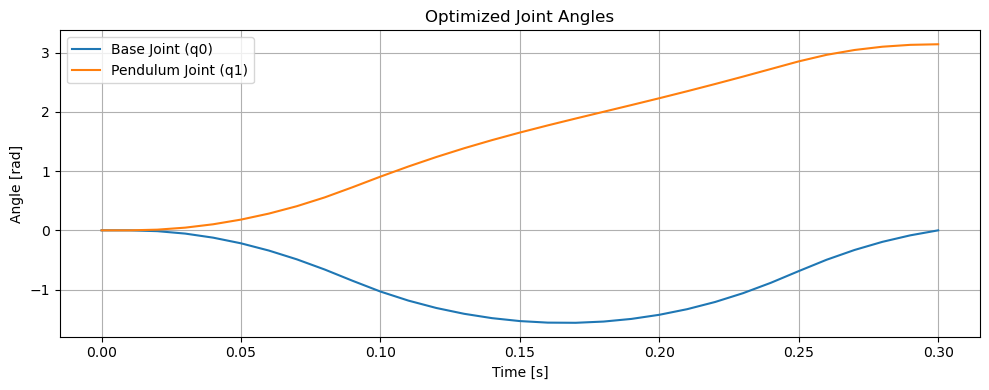

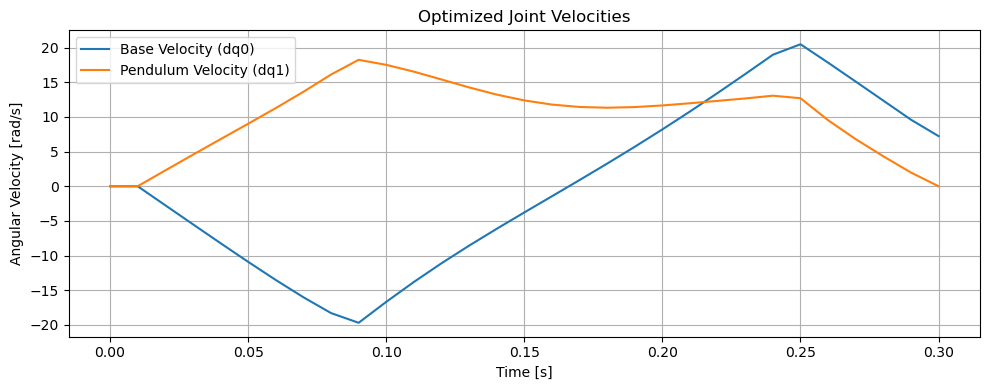

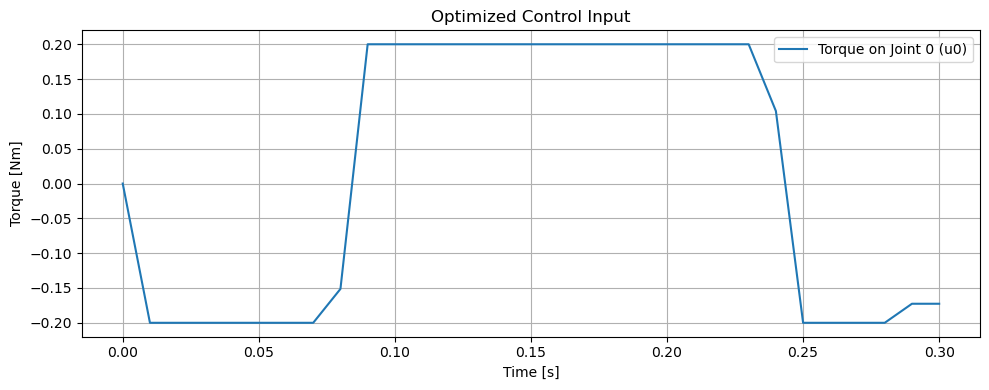

In [5]:
print("Time steps:", time_grid.shape)
print("Torque command shape:", torque_command.shape)
print("First few torques (actual):", torque_command[:5, 0])
print("First few torques (normalized):", torque_command[:5, 0] / parameters_model["max_torque_joint0"])

# === Sample the optimized solution ===
time_vec, q_traj = sol.sample(x, grid='control')
_, dq_traj = sol.sample(v, grid='control')
_, u_traj = sol.sample(u, grid='control')

# === Plot joint positions ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, q_traj[:, 0], label="Base Joint (q0)")
plt.plot(time_vec, q_traj[:, 1], label="Pendulum Joint (q1)")
plt.title("Optimized Joint Angles")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot joint velocities ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, dq_traj[:, 0], label="Base Velocity (dq0)")
plt.plot(time_vec, dq_traj[:, 1], label="Pendulum Velocity (dq1)")
plt.title("Optimized Joint Velocities")
plt.xlabel("Time [s]")
plt.ylabel("Angular Velocity [rad/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot control torque ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, u_traj[:, 0], label="Torque on Joint 0 (u0)")
plt.title("Optimized Control Input")
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the plots, it is evident that the OCP successfully achieves the desired objective, reaching a final angle `θ₂` of 180° (the 180° here is the angle of the pendulum relative to its initial position pointing downards which is the 0° point). The velocity constraint on `θ̇₂` is also correctly enforced, as the velocity is zero at the final time instant.

However, it can be observed that the velocity of the base joint is not zero at the end of the trajectory, indicating that the final state is not fully stable. When an additional constraint is imposed to enforce zero velocity on the base joint at the final time, the problem becomes infeasible, highlighting a trade-off between strict stability conditions and feasibility.



## (b) Combining Motion Planner with provided RL policy
In the next step we integrated the RL policy given to us to stabilise the pendulum at the end of the optimization problem and generate an environment to apply it. The environmetn to visualize on the browser is the one generated by the next code module.

In [6]:
gym.register(
    id="FurutaPendulumTorque-v0",
    entry_point=FurutaPendulumTorqueEnv,
)

# Create an instance of the FurutaPendulumTorqueEnv environment
env = gym.make("FurutaPendulumTorque-v0",
               urdf_model_path=urdf_path, forward_dynamics_casadi_path=forward_dynamics_casadi_path, parameters_model=parameters_model, render=True, swingup=True)

# Click on the url that appears in the output to visualize the environment in a browser

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment FurutaPendulumTorque-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
import torch
from src.agents.ppo_continuous_action import Agent, make_env

saved_model_path = 'data/furuta_pendulum_tensorboard/furutaTorque__ppo_continuous_action__42__1744890705/ppo_continuous_action.cleanrl_model' # no swingup

# Set to False if task includes swingup
swingup = True

envs = gym.vector.SyncVectorEnv(
        [make_env(urdf_path=urdf_path, 
                  parameters_model=parameters_model, 
                  forward_dynamics_casadi_path=forward_dynamics_casadi_path,
                  render=True, swingup=swingup) for _ in range(1)]
    )

model = Agent(envs=envs)

model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# do not use the link printed below, use the one printed above in the previous code module

model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Agent(
  (critic): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

We then combined the OCP solution with the RL policy. The following code is structured such that the RL policy takes control of the environment **immediately after** the control inputs generated by the OCP are exhausted. This setup allows the system to benefit from the optimal initialization provided by the OCP while leveraging the adaptability of the RL policy to complete the task or handle residual dynamics. The simulation is run for 20s (max_steps = 2000).

In [8]:
theta2_vals = []
time_steps = []

# Set 20-second limit (2000 steps)
max_steps = 2000

# Step 1: Reset and start with motion planner
obs, _ = env.reset()
obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

handover_step = -1
for i in range(len(torque_command)):
    if i >= max_steps:
        print("Reached 20-second limit during OCP.")
        break

    u_actual = torque_command[i, 0]
    u_norm = u_actual / parameters_model["max_torque_joint0"]
    obs_np, reward, done, truncated, info = env.step([u_norm])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)
    
    theta2_vals.append(np.arctan2(obs_np[3], obs_np[2]))
    time_steps.append(i)

    if truncated or handover_step > len(torque_command) - 1:
        print(f"OCP terminated at step {i}")
        break

    handover_step = i

print(f"Switching to PPO agent at step {handover_step + 1}")
step = handover_step + 1

while step < max_steps:
    with torch.no_grad():
        action, _, _, _ = model.get_action_and_value(obs, deterministic=True)

    obs_np, reward, done, truncated, info = env.step(action.cpu().numpy()[0])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)

    theta2_vals.append(np.arctan2(obs_np[3], obs_np[2]))
    time_steps.append(step)

    if done or truncated:
        print("PPO agent terminated episode.")
        break

    step += 1

if step >= max_steps:
    print("Reached 20-second limit during PPO.")


Switching to PPO agent at step 31
PPO agent terminated episode.


### Explanation of the Plot

The plot illustrates the evolution of the pendulum joint angle (\(\theta_2\)) over time during the swing-up task.

- In this representation, an angle of **$+\frac{\pi}{2}$ radians (or +90°)** corresponds to the **pendulum hanging vertically downward**, which is the **initial position**.
- An angle of **$-\frac{\pi}{2}$ radians (or -90°)** corresponds to the **upright position**, which is the **target configuration**.

As shown in the plot:
- The pendulum **rapidly swings up** from the downward to the upright position.
- After reaching the upright state, the controller effectively **damps out the residual oscillations**, leading to stable balancing over time.
- The small fluctuations visible around the steady state are minor and reflect natural settling behavior under a smooth control strategy.

This demonstrates that the controller, combining OCP trajectory planning with the provided stabilising RL policy, achieves both **fast convergence** and **stability**.


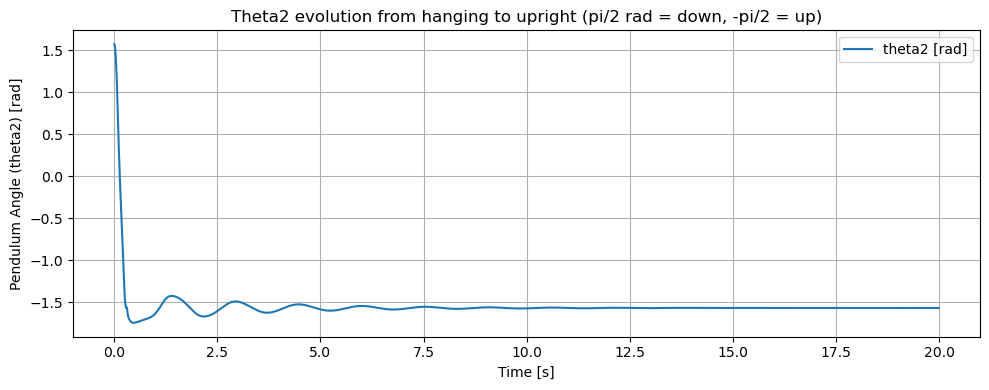

In [14]:
time_array = [i * 0.01 for i in time_steps]

plt.figure(figsize=(10, 4))
plt.plot(time_array, theta2_vals, label='theta2 [rad]')
plt.xlabel('Time [s]')
plt.ylabel('Pendulum Angle (theta2) [rad]')
plt.title('Theta2 evolution from hanging to upright (pi/2 rad = down, -pi/2 = up)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2 Reinforcement Learning for Swing-Up & Stabilising Upright  
## (a) Reinforcement Learning without Domain Randomisation  
### Choice of Learning Algorithm

To train a policy capable of swinging up and stabilising the Furuta pendulum in the upright position, we considered several reinforcement learning algorithms including DDPG, SAC, and PPO. Among these, **Proximal Policy Optimization (PPO)** was selected due to its robustness, simplicity, and strong performance in continuous control problems along with already having a baseline to start from provided (for the no swingup case). PPO's clipped objective helps maintain training stability while allowing effective exploration and learning.

An additional advantage of PPO is that it is well suited for **domain randomisation**, which is required in a later phase of this project. PPO naturally supports training across multiple parallel environments with varying parameters, making it compatible with setups that involve changing physical properties or injecting noise to improve policy robustness.

We based our implementation on the provided PPO algorithm from CleanRL and adapted it to match the **required swing-up task** defined in the project. The following modifications were made in the `ppo_swingup.py` file:

- **Environment**: The environment was updated to `FurutaPendulumSwingupEnv`, which includes the full swing-up dynamics and the necessary reward structure.
- **Swing-up flag**: Set to `True` to ensure the pendulum starts from the downward position and learns to swing up.
- **Reward clipping**: The reward was clipped to the range `[-100, 100]` to reflect the scale of the new reward function used in the swing-up environment.
- **Entropy coefficient**: A small entropy regularisation term (`ent_coef = 0.01`) was introduced to encourage exploration. This is important in tasks like swing-up where the agent must discover effective sequences of actions without immediate reward.
- **Training timesteps**: We experimented with different values for `total_timesteps` and selected `8M` for the main experiments. The effect of this choice will be discussed in the results section.

### Considerations for Noise and Disturbance Handling

Even without domain randomisation, PPO includes several features that help the policy cope with noise and small disturbances in the system:

- **Stochastic action sampling** using a Gaussian distribution, which trains the agent to act under uncertainty
- **Advantage estimation with generalized advantage estimation (GAE)**, which helps filter noise in value predictions
- **Reward normalization and clipping**, which reduce sensitivity to outlier signals
- **Entropy regularisation and gradient clipping**, which improve training stability and reduce overfitting to specific dynamics

These aspects make PPO a good foundation for both the initial learning phase and for future experiments involving disturbance robustness through domain randomisation. 

### Setting up the Swing Up Environment

To support learning the full swing-up and stabilisation task, we built upon the original `furuta_torque_env.py` and implemented a modified environment in `furuta_torque_env_swingup.py`. This updated environment introduces several changes necessary for the pendulum to learn how to swing up from the downward position and maintain balance at the top.

#### Key Modifications

- **Reward Function**:  
  The original environment focused solely on stabilisation, rewarding the pendulum for staying upright. To support the swing-up task, we implemented a new reward function that guides the agent through both phases: swinging up and stabilising.

  The reward is computed as a weighted sum of squared errors between observed and desired values:
  
$$
r = \sum_i -w_i (o_i - d_i)^2 - \alpha \cdot a^2 + \text{bonus}
$$
Where:
- $w_{i}$ are observation weights  
- $o_{i}$ and $d_{i}$ are the current and desired values of sin/cos of joint angles, angular velocities, and base position  
- $\alpha$ is a torque penalty weight to discourage excessive actuation

A **bonus** of **+0.5** is given when the pendulum is upright and still, defined by:

$|\sin(\theta_2)| < 0.1$  
$|\cos(\theta_2) + 1| < 0.1$  
$|d\theta_1| < 0.1 \quad \text{and} \quad |d\theta_2| < 0.1$

  Importantly, we observed that without penalising base rotation and angular velocities, the agent would often swing the pendulum upwards successfully but fail to stabilise it. The pendulum would overshoot due to excessive momentum, making the upright position unstable. By introducing these penalties, the reward function becomes **less sparse**, guiding the agent not just toward the goal but also toward smoother, stabilising behaviours.

- **Time Limit**:  
  Increased from `2000` to `5000` steps to give the agent sufficient time to complete both the swing-up and stabilisation phases. Shorter episodes risked termination before the agent could complete the full behaviour sequence.

- **Termination Penalty**:  
  Increased from `-40` to `-100` to be consistent with the higher reward scale introduced in the new reward function. This also aligns with the reward clipping used in the modified PPO implementation (`[-100, 100]`), ensuring that premature terminations are proportionally penalised.

- **Swing-up Flag**:  
  The `swingup` flag is now set to `True` by default, ensuring episodes begin with the pendulum in the downward position, as required by the task.

These changes make the environment suitable for learning the required swing-up and stabilisation behaviour while ensuring the reward signal is informative enough to guide learning. The full implementation is provided in the `furuta_torque_env_swingup.py` file.


### Training the Model

To train the model, we simply run the ppo_swingup.py in the anaconda terminal with the furuta-rl conda environment active:

`python ppo_swingup.py`

### Analyzing Training Metrics

Several key metrics were monitored during training to verify that the reward function and PPO hyperparameters were effectively guiding the policy towards solving the swing-up task. These metrics provided insight into the agent's learning progress, stability, and whether the final policy could be expected to succeed without manual evaluation.

**Episodic Return** reflects the total reward collected per episode and is the most direct indicator of policy improvement. We expect a clear upward trend, starting from negative values near -100 (due to early failures) and increasing as the agent learns to swing and balance the pendulum. This pattern is visible in all runs, confirming that the reward signal provided sufficient feedback and the policy improved over time.

**Episodic Length** measures how long the agent survives before triggering termination. Initially, lengths are short due to constraint violations, but they gradually increase and stabilize at the maximum episode length once the policy learns to swing and maintain balance. Occasional drops later in training, seen across all runs, indicate failed episodes due to velocity or angle limits being breached.

**Entropy** quantifies how random the agent's actions are. High entropy is desirable at the start to promote exploration, but we expect a steady decline as the policy becomes more confident. This trend is evident, with entropy dropping early and flattening at a low value, indicating successful convergence with reduced exploration.

**Learning Rate** was linearly annealed over time. The plots show the expected gradual decrease for each run, which helps stabilize training as the policy nears convergence.

**Approximate KL Divergence** tracks how much the policy changes between updates. PPO relies on keeping this value moderate. In all runs, the KL divergence fluctuates within a reasonable range, confirming that updates were constrained effectively and policy changes remained stable.

**Clip Fraction** reports the proportion of policy updates where the PPO clipping mechanism was active. A healthy non-zero value during most of training is expected; if it drops to zero too early, learning may stagnate. In our case, clip fraction remains active across the entire training period and only drops near the end, suggesting effective constraint enforcement without early saturation.

**Explained Variance** reflects how well the value function predicts expected returns. It should improve toward 1.0 during training. Our plots show this trend clearly, with all runs reaching high explained variance, though longer runs (8M, 10M) show more fluctuations - likely due to increased diversity in successful episode outcomes.

Together, these trends confirm that the reward function provided meaningful gradients, the PPO algorithm maintained stable updates, and the learned policy successfully converged in each of the tested training durations. The corresponding training plots can be visualised by running the next module in the notebook.


In [16]:
%load_ext tensorboard

%reload_ext tensorboard

%tensorboard --logdir data/furuta_pendulum_swingup_tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Testing the Learned Policy
### Load the pendulum Configuration

Below code loads the provided Furuta Pendulum configuration without the additional unactuated link

In [17]:
import yaml 
import os

with open('src/pendulum_model/pendulum_description/simulation_pendulum.yaml', 'r') as file:
        config = yaml.safe_load(file)

parameters_model = config["parameters_model"]
urdf_path = os.path.join("src/pendulum_model/pendulum_description", config["urdf_filename"])
forward_dynamics_casadi_path = os.path.join("src/pendulum_model/pendulum_description", config["forward_dynamics_casadi_filename"])

### Create the Environment

Creates the environment used for the case when a policy learned by reinforcement learning is used to swing up the pendulum and stabilise it in the upright position. The pendulum starts from the downwards position (swingup = True)

In [18]:
import gymnasium as gym
from src.envs.furuta_torque_env_swingup import FurutaPendulumSwingupEnv

gym.register(
    id="FurutaPendulumSwingup-v0",
    entry_point=FurutaPendulumSwingupEnv,
)


### Load Model & Test it

The following module loads one of the trained models for evaluation. Three models were trained using different values of `total_timesteps` to investigate the trade-off between training duration and policy performance. As expected, increasing the total timesteps generally led to faster and more stable swing-up behavior, but at the cost of longer training time.

The model trained with 8 million timesteps provided the best balance between training efficiency and task performance, achieving rapid swing-up and reliable stabilization. The 3 million-step model required more time to swing up and typically needed two attempts to stabilize. In contrast, the 10 million-step model showed only marginal improvement over the 8 million-step version, suggesting diminishing returns with longer training.

To test a trained model, first load it by running the module below. Then run the next module to evaluate it. To visualise the result, open the simulation link printed by the below module.


In [19]:
import torch
from src.agents.ppo_swingup import Agent, make_env

# saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1749284215/ppo_swingup.cleanrl_model' # 3 million total timesteps which makes the pendulum take longer to swing up with multiple back and forth motions before swinging up and then stabilising also slowly as it first falls back down and then stabilises
saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1747479218/ppo_swingup.cleanrl_model' # 8 million total timesteps which makes the pendulum swing up and stabilise faster
# saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1749286130/ppo_swingup.cleanrl_model' # 10 million total timesteps, faster to stabilise than 8 million

# Set to True as task includes swingup
swingup = True

envs = gym.vector.SyncVectorEnv(
        [make_env(urdf_path=urdf_path, 
                  parameters_model=parameters_model, 
                  forward_dynamics_casadi_path=forward_dynamics_casadi_path,
                  render=True, swingup=swingup) for _ in range(1)]
    )

model = Agent(envs=envs)

model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# Open the visualization link printed in the terminal

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment FurutaPendulumSwingup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Agent(
  (critic): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [20]:
theta2_vals = []
step_counter = 0

observation, info = envs.reset()
time.sleep(2)  # Time to open visualization
terminated = False
truncated = False

while not terminated and not truncated and step_counter < 500:
    action, _, _, _ = model.get_action_and_value(torch.Tensor(observation), deterministic=True)
    action = action.cpu().detach().numpy()
    observation, reward, terminated, truncated, info = envs.step(action)

    theta2 = np.arctan2(observation[0][3], observation[0][2])  # Adjust if observation format differs
    theta2_vals.append(theta2)
    step_counter += 1

envs.close()


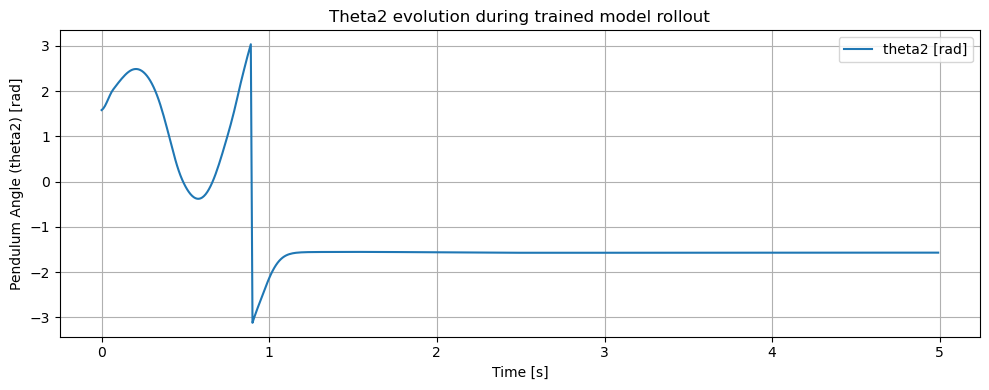

In [21]:
import matplotlib.pyplot as plt

time_array = [i * 0.01 for i in range(len(theta2_vals))]

plt.figure(figsize=(10, 4))
plt.plot(time_array, theta2_vals, label='theta2 [rad]')
plt.xlabel('Time [s]')
plt.ylabel('Pendulum Angle (theta2) [rad]')
plt.title('Theta2 evolution during trained model rollout')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Testing with Disturbances

To evaluate the robustness of the PPO-trained policy, we tested it in a modified environment that includes observation noise, torque noise, and external disturbances. These additions were implemented in the `furuta_torque_env_swingup_noise_disturb.py` and `ppo_swingup_noise_disturb.py` files.

It is important to note that the same policies described above are used here; they were originally trained without domain randomization, noise, or disturbances, learning purely in a clean simulation environment.

The goal of this testing phase is to assess how well the trained policy generalizes under more realistic and imperfect conditions. Specifically, we introduced the following perturbations:

- **Torque noise (`torque_noise_std=0.03`)**: Gaussian noise is added to the applied control signal to simulate actuator inconsistencies. A value of `0.03` corresponds to approximately ±3% variation relative to the maximum torque.

- **Observation noise (`obs_noise_std=0.03`)**: Gaussian noise is added to the observed joint angles and velocities to reflect realistic sensor inaccuracies. The ±3% range represents typical noise levels expected in embedded sensing systems.

- **External disturbances**: Sudden torque impulses are introduced at specific time steps `[100, 1000, 1500, 2000]`, with an amplitude of `0.1`, representing 10% of the system’s maximum torque. These simulate unexpected external forces such as bumps, cable tensions, or environmental interactions. The specific time steps for applying the disturbance were chosen to apply a disturbance during the swing up phase (at 1s), then at 3 instances during the stable phase (at 10, 15, and 20s).

By running the model in this perturbed environment, we can evaluate its baseline robustness and observe how well it handles noise and recovers from disturbances, despite not being exposed to such effects during training.


In [22]:
import gymnasium as gym
from src.envs.furuta_torque_env_swingup_noise_disturb import FurutaPendulumSwingupEnv

gym.register(
    id="FurutaPendulumSwingup-v0",
    entry_point=FurutaPendulumSwingupEnv,
)

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment FurutaPendulumSwingup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [23]:
import torch
import gymnasium as gym
from src.agents.ppo_swingup_noise_disturb import Agent, make_env

# Load the correct model (e.g. trained with 8M timesteps)
# saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1749284215/ppo_swingup.cleanrl_model' # 3 million total timesteps which makes the pendulum take longer to swing up with multiple back and forth motions before swinging up and then stabilising also slowly as it first falls back down and then stabilises
saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1747479218/ppo_swingup.cleanrl_model' # 8 million total timesteps which makes the pendulum swing up and stabilise faster
# saved_model_path = 'data/furuta_pendulum_swingup_tensorboard/furutaTorqueSwingup__ppo_swingup__42__1749286130/ppo_swingup.cleanrl_model' # 10 million total timesteps, faster to stabilise than 8 million

# Set task type
swingup = True

# Create environment with same noise/disturbance config used during training
envs = gym.vector.SyncVectorEnv([
    make_env(
        urdf_path=urdf_path,
        parameters_model=parameters_model,
        forward_dynamics_casadi_path=forward_dynamics_casadi_path,
        render=True,
        swingup=swingup,
        apply_noise=True,
        torque_noise_std=0.03,
        obs_noise_std=0.03,
        apply_disturbance=True,
        disturbance_steps=[100, 1000, 1500, 2000],
        disturbance_amplitude=0.1 # disturbance of 10% of max torque
    )
])

# Load trained agent
model = Agent(envs=envs)
model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# Open the visualization link printed in the terminal

model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Agent(
  (critic): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [24]:
import time
import torch
import numpy as np

theta2_vals = []
step_counter = 0

observation, info = envs.reset()
time.sleep(2)  # Give time to open the browser window

terminated = [False]
truncated = [False]

print(f"Initial Observation: {observation}")

while not terminated[0] and not truncated[0] and step_counter < 2500:
    # Get action from trained model
    action, _, _, _ = model.get_action_and_value(torch.tensor(observation, dtype=torch.float32), deterministic=True)
    action = action.cpu().detach().numpy()

    # Step the environment
    observation, reward, terminated, truncated, info = envs.step(action)

    # Extract and store theta2
    theta2 = np.arctan2(observation[0][3], observation[0][2])  # Adjust indexing if needed
    theta2_vals.append(theta2)
    step_counter += 1

    # Optional: print at intervals instead of every step
    if step_counter % 50 == 0:
        print(f"Step {step_counter}, theta2: {theta2:.3f}, reward: {reward}")

envs.close()


Initial Observation: [[0. 1. 0. 1. 0. 0. 0.]]


c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Step 50, theta2: 0.230, reward: [-0.06320388]
Step 100, theta2: -3.086, reward: [-0.03391975]
[DEBUG] Disturbance applied at step 100: +0.1
Step 150, theta2: -2.376, reward: [-0.01120442]
Step 200, theta2: -2.823, reward: [-0.02788433]
Step 250, theta2: -1.620, reward: [0.79626272]
Step 300, theta2: -1.535, reward: [0.13128805]
Step 350, theta2: -1.534, reward: [0.07321374]
Step 400, theta2: -1.580, reward: [0.05893616]
Step 450, theta2: -1.440, reward: [-1.136364e-05]
Step 500, theta2: -1.598, reward: [-6.27781943e-06]
Step 550, theta2: -1.626, reward: [0.04301526]
Step 600, theta2: -1.564, reward: [0.04167693]
Step 650, theta2: -1.573, reward: [0.04062698]
Step 700, theta2: -1.503, reward: [0.03930312]
Step 750, theta2: 1.527, reward: [-0.0015499]
Step 800, theta2: -1.490, reward: [-8.7875643e-06]
Step 850, theta2: -1.520, reward: [-5.62808518e-06]
Step 900, theta2: -1.514, reward: [-5.04122899e-06]
Step 950, theta2: -1.576, reward: [-2.43356105e-06]
Step 1000, theta2: -1.453, reward

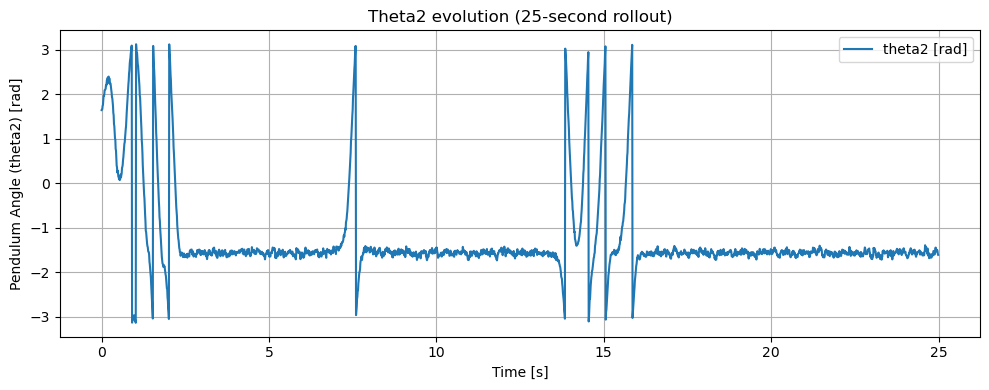

In [25]:
import matplotlib.pyplot as plt

time_array = [i * 0.01 for i in range(len(theta2_vals))]

plt.figure(figsize=(10, 4))
plt.plot(time_array, theta2_vals, label='theta2 [rad]')
plt.xlabel('Time [s]')
plt.ylabel('Pendulum Angle (theta2) [rad]')
plt.title('Theta2 evolution (25-second rollout)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Limitations

Although the PPO-trained policy successfully solves the swing-up and stabilization task in a clean simulation, it demonstrates clear limitations when tested under more challenging conditions not encountered during training. In particular, the policy was not trained with domain randomisation or perturbations, and thus exhibits reduced robustness to environmental uncertainties. When tested with observation and torque noise above a standard deviation of 0.03, the pendulum frequently fails to maintain the upright position after swing-up, often drifting away and requiring another swing-up attempt. Similarly, larger external disturbances (larger than 10% of max toruqe) applied during the stabilization phase disrupt the balance, causing the pendulum to fall and necessitating repeated recovery maneuvers. For cases with larger or frequent disturbances, the pendulum is also not able to recover and ends up swinging infinitely. These behaviors highlight the policy's sensitivity to unmodeled variability and the need for robustness-focused training techniques, such as domain randomisation, to better handle such real-world perturbations. Disturbances of 10% during the initial swingup also cause the pendulum not to immediately stabilise (as was seen in the case without disturbances), requiring a second swingup to stabilise.


## (b) Reinforcement Learning with Domain Randomisation

To improve robustness against modelling inaccuracies and system variability, we extend the baseline PPO swing-up agent by introducing domain randomisation. This technique exposes the agent during training to a range of physically plausible variations in the system's parameters, encouraging the policy to learn strategies that generalise across a broader range of dynamics.

The policy training implementation is defined in the `ppo_swingup_random.py` script and uses a modified environment class, `FurutaPendulumSwingupRandomEnv`, implemented in `furuta_torque_env_swingup_domain_randomisation.py`. Unlike the baseline setup in `ppo_swingup.py` and `furuta_torque_env_swingup.py`, where the system parameters are fixed, the domain randomisation version samples new physical parameters at every environment reset. These sampled parameters directly affect the pendulum’s dynamics.

A critical distinction in our approach is that we do not reuse the precomputed CasADi dynamics from the original environment, which would assume fixed parameters. Instead, we dynamically construct the system's forward dynamics at runtime using Pinocchio functions with the newly sampled parameters. This ensures that each environment rollout is consistent with the altered physics and avoids misleading the learning algorithm with inconsistent transitions.

The randomisation is applied to key physical parameters, with each sampled from a bounded range relative to their nominal value. The selected randomisation ranges are as follows:

- `m1`, `m2`: (0.8, 1.2)
- `l1`, `l2`: (0.9, 1.1)
- `L1`, `L2`: (0.8, 1.2)
- `J1`, `J2`: (0.8, 1.2)
- `b1`, `b2`: (0.7, 1.3)

These ranges were chosen based on expected physical variability. The viscous friction coefficients (`b1`, `b2`) were given the widest bounds, as friction is typically the most uncertain and sensitive to environmental conditions (e.g. wear, lubrication, temperature). In contrast, the link lengths (`l1`, `l2`) were varied only slightly, reflecting the fact that geometric dimensions are known with relatively high precision and are less likely to differ significantly from their nominal values in a physical system.

### Reward Function Consistency

It is important to note that the reward function remains unchanged from the baseline environment. This design choice was intentional to ensure that improvements in robustness can be attributed to the agent’s exposure to variable dynamics, rather than differences in task specification. The reward function continues to incentivize pendulum swing-up, minimization of oscillation, and energy-efficient stabilization. By maintaining reward consistency, we facilitate fair comparison with agents trained without domain randomisation. The same reward function as the case without domain randomisation was observed to give good results when testing the learned policy.


### Training the Model

To train the model, we simply run the ppo_swingup.py in the anaconda terminal with the furuta-rl conda environment active:

`python ppo_swingup_random.py`

### Visualise Training Metrics

Running the following module shows the metrics which were monitored during the training. The same considerations as were done in part (a) apply here too.

In [26]:
%load_ext tensorboard

%reload_ext tensorboard

%tensorboard --logdir data/furuta_pendulum_swingup_random_tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
import gymnasium as gym
from src.envs.furuta_torque_env_swingup_noise_disturb import FurutaPendulumSwingupEnv

gym.register(
    id="FurutaPendulumSwingup-v0",
    entry_point=FurutaPendulumSwingupEnv,
)


c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment FurutaPendulumSwingup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [28]:
import torch
import gymnasium as gym
from src.agents.ppo_swingup_noise_disturb import Agent, make_env

# Load the model trained with domain randomisation
# saved_model_path = 'data/furuta_pendulum_swingup_random_tensorboard/furutaTorqueSwingupRandom__ppo_swingup_random__42__1749311236/ppo_swingup_random.cleanrl_model' # 10 million total timesteps, more frequently able to keep the pendulum upright even with disturbances without pendulum losiing balance and needing to recover but frequently fails to recover if balance is lost
saved_model_path = 'data/furuta_pendulum_swingup_random_tensorboard/furutaTorqueSwingupRandom__ppo_swingup_random__42__1749318668/ppo_swingup_random.cleanrl_model' # 8 million total timesteps, has instances of pendulum losing balance with larger disturbances but able to recover and stay upright

# Set task type
swingup = True

# Create environment with same noise/disturbance config used during training
envs = gym.vector.SyncVectorEnv([
    make_env(
        urdf_path=urdf_path,
        parameters_model=parameters_model,
        forward_dynamics_casadi_path=forward_dynamics_casadi_path,
        render=True,
        swingup=swingup,
        apply_noise=True,
        torque_noise_std=0.05,
        obs_noise_std=0.05,
        apply_disturbance=True,
        # disturbance_steps=[100, 1000, 1500, 2000],
        disturbance_steps=[100, 200, 500, 800, 1000, 1500, 2000], # even with more frequent disturbances, the agent is able to recover and keep the pendulum upright
        disturbance_amplitude=0.3 # disturbance of 30% of max torque
        # disturbance_amplitude=0.2 # disturbance of 20% of max torque
    )
])

# Load trained agent
model = Agent(envs=envs)
model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# Open the visualization link printed in the terminal

model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


Agent(
  (critic): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
import time
import torch
import numpy as np

# Storage
theta2_vals = []
step_counter = 0

# Reset environment
observation, info = envs.reset()
time.sleep(2)  # Allow browser time to open

terminated = [False]
truncated = [False]

print(f"Initial Observation: {observation}")

while not terminated[0] and not truncated[0] and step_counter < 2500:
    # Predict action from trained model
    action, _, _, _ = model.get_action_and_value(torch.tensor(observation, dtype=torch.float32), deterministic=True)
    action = action.cpu().detach().numpy()

    # Step environment
    observation, reward, terminated, truncated, info = envs.step(action)

    # Extract theta2
    theta2 = np.arctan2(observation[0][3], observation[0][2])
    theta2_vals.append(theta2)
    step_counter += 1

    if step_counter % 50 == 0:
        print(f"Step {step_counter}, theta2: {theta2:.3f}, reward: {reward}")

envs.close()


Initial Observation: [[0. 1. 0. 1. 0. 0. 0.]]
Step 50, theta2: -0.058, reward: [-0.05135314]
Step 100, theta2: 2.548, reward: [-0.08727222]
[DEBUG] Disturbance applied at step 100: +0.3
Step 150, theta2: -1.639, reward: [0.36729484]
Step 200, theta2: -1.646, reward: [-3.29230704e-05]
[DEBUG] Disturbance applied at step 200: +0.3
Step 250, theta2: -1.462, reward: [-4.64220006e-05]
Step 300, theta2: -1.453, reward: [-2.58847893e-05]
Step 350, theta2: -1.605, reward: [-2.54658484e-05]
Step 400, theta2: -1.521, reward: [0.09353832]
Step 450, theta2: -1.581, reward: [-1.94080963e-05]
Step 500, theta2: -1.587, reward: [0.08690307]
[DEBUG] Disturbance applied at step 500: +0.3
Step 550, theta2: -1.623, reward: [-5.89378994e-06]
Step 600, theta2: -1.015, reward: [-0.00027587]
Step 650, theta2: -1.639, reward: [-1.6999109e-05]
Step 700, theta2: -0.230, reward: [-0.00139224]
Step 750, theta2: -1.729, reward: [-3.9368796e-05]
Step 800, theta2: -1.326, reward: [-8.48898269e-05]
[DEBUG] Disturbance

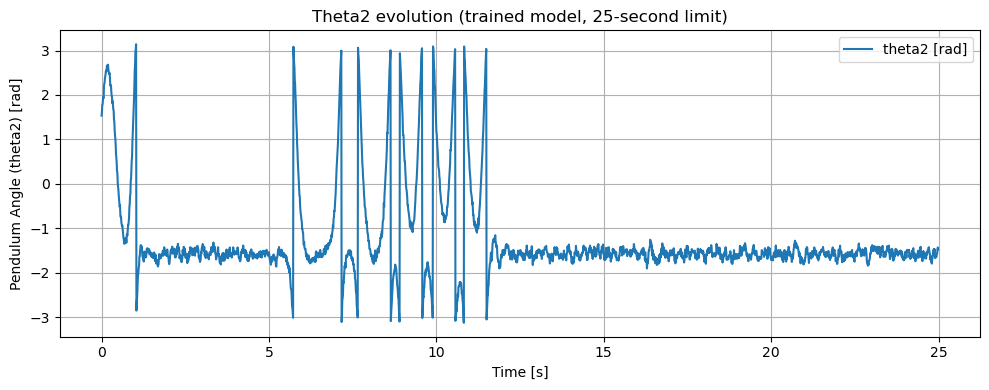

In [30]:
import matplotlib.pyplot as plt

time_array = [i * 0.01 for i in range(len(theta2_vals))]

plt.figure(figsize=(10, 4))
plt.plot(time_array, theta2_vals, label='theta2 [rad]')
plt.xlabel('Time [s]')
plt.ylabel('Pendulum Angle (theta2) [rad]')
plt.title('Theta2 evolution (trained model, 25-second limit)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Results of Testing

The model trained using domain randomization is able to effectively handle larger torque and observation noise (up to 5%), as well as external disturbances with amplitudes up to 30% of the maximum torque (still causes it to lose stability but it is able to recover by swinging up again). This demonstrates the effectiveness of domain randomization in improving the policy's robustness to sensor noise and unexpected perturbations during deployment. Even with more frequent disturbances, the policy trained with domain randomization is able to recover after losing stability by swinging up again and stabilising the pendulum.

While the benefits in generalization and robustness are evident, domain randomization does introduce certain trade-offs. Training can be slower and more unstable due to the broader range of dynamics the policy must learn to cope with. The resulting policy, although robust, may be less finely tuned for a specific environment compared to a policy trained without randomization.

Interestingly, testing revealed different behavioral tendencies between models trained for different durations. The policy trained for 10 million timesteps was more successful at maintaining balance when a disturbance was applied, suggesting it had become robust to parameter variation and small perturbations. However, once the pendulum was knocked out of balance, this model frequently failed to recover and instead entered an oscillatory swing-up pattern without stabilizing again. This may indicate that the longer training caused the policy to overfit to the randomized dynamics without experiencing or adapting to recovery scenarios.

In contrast, the model trained for 8 million timesteps was slightly more sensitive to disturbances and more likely to lose balance initially. However, it consistently managed to recover and stabilize the pendulum after such perturbations. This suggests a more flexible policy that, while not as resistant to disturbance, retained a more general ability to recover from instability.

This comparison highlights an important nuance: robustness does not only involve resisting disturbances but also the capacity to recover from them. Excessive training on randomized but disturbance-free data may cause a policy to lose this adaptability, underscoring the importance of including recovery scenarios in the training curriculum if that is a desired capability.

> **Note:** The explained variance of the 10M policy drops significantly during training, suggesting reduced generalization. This aligns with observed behavior where the policy is less able to adapt to recovery situations, despite performing well under stable conditions.


## 3. Comparison of Model-Based Approach and Reinforcement Learning Approach

The two control strategies can be compared along three key dimensions:

- **Task Completion Time**  
  Measures how quickly each approach is able to swing up and stabilize the pendulum. Faster completion may indicate more efficient planning or control.

- **Robustness to Noise and Disturbances (Generalizability)**  
  Evaluates how well each approach handles unexpected changes in dynamics, sensor noise, or initial conditions. This reflects the controller's ability to generalize beyond its training or design assumptions.

- **Implementation Complexity and Requirements**  
  Considers the effort and expertise required to develop each controller. This includes factors such as model accuracy requirements, tuning effort, training data, computational cost, and reliance on simulators or analytical models.


### Time Comparison

#### Model-Based Approach

Implementing the model-based approach led to a significantly faster and more consistent swing-up time for the pendulum. The task was completed in approximately **0.3 seconds**, with the motion trajectory directly guiding the pendulum toward the desired target without unnecessary oscillations or repeated attempts. As shown in the plots provided in the first section, the system follows an optimized trajectory tailored to the task, demonstrating the effectiveness of model-based planning.

#### Reinforcement Learning (RL) Approach

In contrast, the RL-based approach resulted in a slower and less reliable swing-up. The average time required to complete the task was approximately **$1.2$ seconds**, and the trajectories often showed delayed convergence to the goal. The pendulum frequently needed multiple correction attempts, leading to less efficient and more variable motion. This reflects the exploratory nature of RL policies and their reduced ability to exploit precise system dynamics compared to model-based optimization.


## Robustness

### Model-Based Approach

The model-based approach is inherently less robust to external disturbances, as it relies on an open-loop feedforward trajectory computed by the optimal control problem (OCP). This trajectory assumes ideal conditions, and the reinforcement learning (RL) policy used to stabilize the system operates within constrained action bounds, limiting its ability to correct unexpected deviations. As a result, even small disturbances can cause the strategy to fail.

To evaluate this, a custom environment (`furuta_torque_env_swingup_noise_disturb.py`) was created, allowing controlled disturbances and noise to be introduced into the system. This enabled systematic testing of the robustness of different control strategies.

Experiments using the combined OCP + RL strategy in a disturbed environment revealed that a torque disturbance of just 2% of the input value was sufficient to consistently destabilize the system and prevent successful swing-up. Adding noise to the input torque further reduced robustness, as it disturbed the optimized feedforward trajectory even more. The trajectory planner relies on an ideal feedforward execution; any deviation can prevent the pendulum from reaching the precise upright position required to successfully switch to the RL policy for stabilization.

To cope with such disturbances and noise, a more advanced model-based control strategy would be necessary. This would involve identifying a realistic model of the Furuta pendulum that includes sensor and actuator noise, as well as natural environmental disturbances.

The following code initializes the environment with the added disturbances and noise:


In [31]:
from src.envs.furuta_torque_env_swingup_noise_disturb import FurutaPendulumSwingupEnv

gym.register(
    id="FurutaPendulumTorque-v1",
    entry_point=FurutaPendulumSwingupEnv,
)

env = gym.make(
    "FurutaPendulumTorque-v1",
    urdf_model_path=urdf_path,
    forward_dynamics_casadi_path=forward_dynamics_casadi_path,
    parameters_model=parameters_model,
    render=True,
    swingup=True,
    apply_disturbance=True,
    apply_noise=False, # not applying noise to the observations or torques
    torque_noise_std=0.03,
    obs_noise_std=0.03,
    disturbance_steps=[10, 25],
    disturbance_amplitude=0.02 
)

model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [32]:
import torch
from src.agents.ppo_continuous_action import Agent, make_env

saved_model_path = 'data/furuta_pendulum_tensorboard/furutaTorque__ppo_continuous_action__42__1744890705/ppo_continuous_action.cleanrl_model' # no swingup

# Set to False if task includes swingup
swingup = True

envs = gym.vector.SyncVectorEnv(
        [make_env(urdf_path=urdf_path, 
                  parameters_model=parameters_model, 
                  forward_dynamics_casadi_path=forward_dynamics_casadi_path,
                  render=True, swingup=swingup) for _ in range(1)]
    )

model = Agent(envs=envs)

model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# do not use the link printed below, use the one printed above in the previous code module

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment FurutaPendulumTorque-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


model name: furuta_pendulum
q: [0. 0.]
T_pin:   R =
           1            0            0
           0           -1  1.22465e-16
           0 -1.22465e-16           -1
  p =    0.093525 1.57979e-17       0.055

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


Agent(
  (critic): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

### To Run the Simulation of OCP + RL

To evaluate the combined performance of the OCP and the RL policy under disturbances, the following code can be used. This initializes the custom environment with injected noise and disturbances, applies the OCP-generated control sequence for the initial swing-up, and then switches to the PPO policy for stabilization:

In [33]:
# Step 1: Reset and start with motion planner
obs, _ = env.reset()
obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # For PPO agent later

# Step 2: Apply OCP torques first
handover_step = -1
for i in range(len(torque_command)):
    u_actual = torque_command[i, 0]
    u_norm = u_actual / parameters_model["max_torque_joint0"]

    obs_np, reward, done, truncated, info = env.step([u_norm])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)

    if truncated or handover_step > len(time_grid) - 1:
        print(f"OCP terminated at step {i}")
        break

    handover_step = i

# Step 3: Switch to learned PPO model
print(f"Switching to PPO agent at step {handover_step + 1}")

while True:
    with torch.no_grad():
        action, _, _, _ = model.get_action_and_value(obs, deterministic=True)

    obs_np, reward, done, truncated, info = env.step(action.cpu().numpy()[0])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)

    if done or truncated:
        print("PPO agent terminated episode.")
        break

[DEBUG] Disturbance applied at step 10: +0.02
[DEBUG] Disturbance applied at step 25: +0.02
Switching to PPO agent at step 31
PPO agent terminated episode.


### RL Approach

The RL approach is expected to be more robust than the model-based strategy, as previously discussed and showcased in detail in Question 2. Unlike a feedforward trajectory, an RL policy is inherently reactive and can adapt to unexpected disturbances during execution.

When tested in the environment with injected disturbances, the baseline PPO policy, trained without domain randomization, was able to stabilize the system under **3% observation noise** and **torque disturbances up to 10%**, demonstrating a notably higher robustness compared to the model-based approach. Even when disturbances temporarily pushed the pendulum away from the upright position, the policy was able to autonomously perform a new swing-up and re-stabilize without external intervention.

Furthermore, training the policy using **domain randomization** significantly improved its resilience. This version of the policy could withstand up to **5% observation noise** and **30% torque disturbances** while maintaining stable performance, confirming that domain randomization enhances the generalization and robustness of the learned control strategy.


## Complexity of the Approach

### Model-Based Approach

The model-based approach involves relatively low setup complexity. It requires the definition of a straightforward OCP, which integrates the URDF model, a YAML configuration file containing system parameters, and the dynamic model of the Furuta pendulum. Once defined, the OCP formulation can be solved using standard tools without the need for extensive parameter tuning.

However, a key limitation is that the OCP alone cannot complete the task. While it provides an optimal feedforward trajectory for swing-up, it lacks feedback capability, making it insufficient for robust stabilization in the presence of disturbances or model inaccuracies.

### RL Approach

In contrast, the RL-based approach introduces significantly higher complexity in both implementation and training. A well-designed reward function must be carefully crafted to avoid sparsity and to encourage the desired behavior. The learning outcome is highly sensitive to training duration: insufficient training may result in failure to complete the task, while excessive training may lead to overfitting to the training conditions.

Moreover, the training process is computationally intensive and time-consuming, often requiring millions of simulation steps to converge. It also demands careful tuning of hyperparameters, environment-specific wrappers, and policy architectures. Domain randomization or curriculum learning strategies may be needed to improve generalization, further increasing complexity.


## 4 Addition of Unactuated Link to Pendulum
## Code snippet of the .URDF file of the new joint

The new link and joint added are considered identical to the one already existing.

### Additional Link and Joint in URDF

To implement the additional link in the `.urdf` file, the following code was added. It introduces a **revolute joint** between the existing pendulum arm (`arm2`) and a new arm (`arm3`). The **end effector** is then attached at the end of this extended link chain.

```xml
<!-- Additional unactuated joint for Question 4 -->
<joint name="joint2" type="revolute">
  <origin rpy="-3.141592653589793 0.0 0.0" xyz="0.0 0.0 0.129"/>
  <parent link="arm2"/>
  <child link="arm3"/>
  <axis xyz="1 0 0"/> <!-- Adjust axis direction as needed -->
  <dynamics damping="1.7905703040590617e-05"/>
  <limit effort="0.43" velocity="100.0"/>
</joint>

<link name="arm3">
  <visual>
    <origin rpy="0 0 0" xyz="0 0 -0.0645"/>
    <geometry>
      <cylinder length="0.129" radius="0.005"/>
    </geometry>
    <material name="black"/>
  </visual>
  <collision>
    <origin rpy="0 0 0" xyz="0 0 -0.0645"/>
    <geometry>
      <cylinder length="0.129" radius="0.005"/>
    </geometry>
  </collision>
  <inertial>
    <mass value="0.009801"/>
    <origin rpy="0.0 0.0 0.0" xyz="0.0 0.0 0.096608"/>
    <inertia ixx="0.000014790595" ixy="0.0" ixz="0.0" 
             iyy="0.000014790595" iyz="0.0" izz="1e-06"/>
  </inertial>
</link>

<joint name="end_effector_joint" type="fixed">
  <origin rpy="0.0 0.0 0.0" xyz="0.0 0.0 0.258"/>
  <parent link="arm3"/>
  <child link="end_effector"/>
</joint>

<link name="end_effector">
</link>



### Modified `.yaml` File for Additional Joint and Link

The `.yaml` file is updated to include parameters for the newly added link (`arm3`) and revolute joint (`joint2`). The following entries define the physical and dynamic properties of the third link and joint, maintaining consistency with the previous structure.

```yaml
parameters_model:
  m1: 0.040466
  m2: 0.009801
  m3: 0.009801              # Mass of the new link

  l1: 0.05415
  l2: 0.096608
  l3: 0.096608              # COM of new link 

  L1: 0.093525
  L2: 0.129
  L3: 0.129                # Length of new link 

  J1: 5.96237099e-04
  J2: 0.000014790595
  J3: 0.000014790595        # Inertia of new link 

  b1: 1.16511498e-02
  b2: 1.7905703040590617e-05
  b3: 1.7905703040590617e-05  # Damping for Q4 (same as b2)

  max_velocity_joint0: 22.0
  max_velocity_joint1: 50.0
  max_velocity_joint2: 50.0   

  max_angle_joint0: 6.283185307179586
  max_angle_joint1: 6.283185307179586
  max_angle_joint2: 6.2831592653589793

  max_torque_joint0: 0.2


### Adaptation of the Environment for the Third Joint

To integrate the third joint into the simulation environment, the following key modifications were made in the `FurutaPendulumSimulator` and `FurutaPendulumTorqueEnv` classes:

- The **state vector** `self.x` was extended to 6 elements: 3 joint positions and 3 joint velocities (`[θ₁, θ₂, θ₃, θ̇₁, θ̇₂, θ̇₃]`).
- The **initial position and velocity arrays** (`init_qpos`, `init_qvel`) were expanded to include the third joint, and used to initialize `self.pendulum_sim.x`.
- The **CasADi dynamics function** `create_f_state_transition` now handles a 6D state vector (3 positions + 3 velocities) and uses the third joint in `q_sym`, `dq_sym`, and `ddq_sym`.
- The **visualizer display call** was updated with a 3-element configuration (`q_init = np.array([0, 0, 0])`) to match the updated model.
- The **maximum velocity and angle limits** for `joint2` were added (`_max_velocity_joint2`, `_max_angle_joint2`) and used in termination conditions.
- The **observation vector** was extended to 10 dimensions, including `sin(θ₃)`, `cos(θ₃)`, normalized `𝜃̇₃`, and scaled `θ₁`.
- The **reward function** in the non-swingup case includes terms to penalize deviations in both `θ₂` and `θ₃` from the upright position (`π`) and includes weights for `𝜃̇₃`.

These changes ensure the simulator correctly models the extended 3-joint Furuta pendulum and the environment handles the larger state and observation spaces accordingly.



### Extending PPO to Support a Three-Joint System

This PPO implementation has been adapted to handle a more complex system with three degrees of freedom by integrating the new custom environment (`FurutaPendulumTorqueEnv`) that reflects the updated dynamics. The registration of this new environment (`FurutaPendulumTorque_Q4-v0`) through the `gym.register()` function ensures that the PPO agent interacts with a simulation that includes the third unactuated joint. The observation and action spaces are automatically adjusted to match the increased dimensionality, and the `Agent` class uses these updated shapes to define the input and output layers of both the policy and value networks. Moreover, the system parameters, URDF model, and CasADi dynamics are loaded from a YAML configuration file specifically prepared for the three-joint model, ensuring consistent dynamics throughout training. The vectorized environment setup and training loop remain structurally unchanged, making this implementation flexible and scalable to higher-dimensional control problems with minimal modifications.


### ADAPTATION OF THE ENVIRONMENT CODE TO NEW URDF AND NEW DYNAMICS FILE


In [46]:
import os
import time
import yaml
import numpy as np
import casadi as ca
from rockit import *
from matplotlib import pyplot as plt
import pinocchio as pin
import pinocchio.casadi as cpin
from pinocchio.visualize import MeshcatVisualizer as PMV
import meshcat
import meshcat.transformations as tf
import gymnasium as gym

import torch
from src.agents.ppo_continuous_action import Agent, make_env


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Model Loading and Visualization

The code loads the updated `.yaml` and `.urdf` files for the three-joint pendulum model. It also opens a visualization window to verify that the URDF model is correctly structured.


In [1]:
with open('src/pendulum_model/NEW_PENDULUM_DESCRIPTION/NEW_simulation_pendulum_Q4.yaml', 'r') as file:
        config = yaml.safe_load(file)

parameters_model = config["parameters_model"]
urdf_model_path  = 'src/pendulum_model/NEW_PENDULUM_DESCRIPTION/NEW_furuta_pendulum_Q4.urdf'
forward_dynamics_casadi_path = 'src/pendulum_model/NEW_PENDULUM_DESCRIPTION/NEW_forward_dynamics_Q4.casadi'


mesh_dir = "meshes"

# Load the urdf model
model, collision_model, visual_model = pin.buildModelsFromUrdf(
    urdf_model_path, mesh_dir
)
print("model name: " + model.name)
frame_name= "end_effector"
print (model.getFrameId(frame_name))
# Create data required by the algorithms
data, collision_data, visual_data = pin.createDatas(
    model, collision_model, visual_model
)

# Define the equivalent casadi model and data
cmodel = cpin.Model(model)
cdata = cmodel.createData()

# Visualize robot
viz = PMV(model, collision_model, visual_model, collision_data=collision_data, visual_data=visual_data)
viz.initViewer(open=False)
viz.loadViewerModel(rootNodeName="robot")
viz.display(np.zeros(model.nv))

NameError: name 'yaml' is not defined

### Loading Simulation Configuration Files

This code loads the simulation configuration from a `.yaml` file, including model parameters and file paths for the URDF and CasADi dynamics model.


In [50]:
with open('src/pendulum_model/NEW_PENDULUM_DESCRIPTION/NEW_simulation_pendulum_Q4.yaml', 'r') as file:
        config = yaml.safe_load(file)

parameters_model = config["parameters_model"]
urdf_path = os.path.join("src/pendulum_model/NEW_PENDULUM_DESCRIPTION", config["urdf_filename"])
forward_dynamics_casadi_path = os.path.join("src/pendulum_model/NEW_PENDULUM_DESCRIPTION", config["forward_dynamics_casadi_filename"])

### Adaptation of the Optimal Control Problem for the Third Joint

The optimal control problem was updated to support a third unactuated joint, with the following changes:

- **State and control dimensions** were increased to handle 3 joint angles and 3 joint velocities (`x`, `v`) and 3 torques (`u`), even though only joint 0 is actuated.
- **Joint limits (`q_min`, `q_max`) and velocity bounds (`v_min`, `v_max`)** were extended to include the third joint.
- **Control bounds (`u_min`, `u_max`)** were specified such that only `u[0]` is actuated; other inputs remain zero.
- **Boundary conditions** were added at `t₀` and `t_f` for both positions and velocities, including zero velocity targets for joint 2 and 3 at final time.
- **The forward dynamics function** was modified to apply torque only to the first joint.
- **The objective function** now penalizes deviation of both `θ₂` and `θ₃` from the upright position, enabling coordinated stabilization of both pendulum arms.

These changes allow the OCP to generate torque commands that swing up and stabilize the system while accounting for the extended dynamics.


In [51]:
T_fixed = 0.9
ocp = Ocp(T=T_fixed)
N = 90
M = 1

q_min = np.array([-parameters_model["max_angle_joint0"], -parameters_model["max_angle_joint1"],-parameters_model["max_angle_joint2"]])
q_max = np.array([ parameters_model["max_angle_joint0"],  parameters_model["max_angle_joint1"],  parameters_model["max_angle_joint2"]])

v_min = np.array([-parameters_model["max_velocity_joint0"], -0.5*parameters_model["max_velocity_joint1"], -0.5*parameters_model["max_velocity_joint2"]])
v_max = -v_min

u_min = np.array([-parameters_model["max_torque_joint0"], 0.0,0.0])  # only joint 0 actuated
u_max = -u_min

q_start = np.array([0,0,0])
q_goal = np.array([0.0, np.deg2rad(180),0])

q_sym = ca.MX.sym('q', 3)
v_sym = ca.MX.sym('v', 3)
u_sym = ca.MX.sym('u', 3)

x = ocp.state(len(q_min))
v = ocp.state(len(q_min))
u = ocp.control(len(q_min))

ocp.subject_to(ocp.at_t0(x) == q_start)
ocp.subject_to(ocp.at_t0(v) == 0)
ocp.subject_to(ocp.at_t0(u[0]) == 0)
ocp.subject_to(ocp.at_tf(x) == q_goal)
ocp.subject_to(ocp.at_tf(v[1]) == 0)
ocp.subject_to(ocp.at_tf(v[2])== 0)
# ocp.subject_to(ocp.at_tf(u[0]) == 0)

# Dummy forward dynamics function for demonstration
forward_dynamics_raw = ca.Function.load(forward_dynamics_casadi_path)

def forward_dynamics_ca(q, dq, tau):
    return forward_dynamics_raw(q, dq, tau[0])  # Only joint 0 is actuated


ocp.set_der(x, v)
ocp.set_der(v, forward_dynamics_ca(x, v, u))

ocp.method(MultipleShooting(N=N, M=M, intg='rk'))

ocp.subject_to(x >= q_min)
ocp.subject_to(x <= q_max)

ocp.subject_to(v >= v_min)
ocp.subject_to(v <= v_max)

ocp.subject_to(u >= u_min)
ocp.subject_to(u <= u_max)

theta2 = x[1]
dtheta2 = v[1]
theta2_goal = q_goal[1]

theta3 = x[2]
dtheta3 = v[2]
theta3_goal = q_goal[2]


# Penalize deviation from upright and minimize pendulum velocity + control effort
ocp.add_objective(ocp.integral(10 * (theta2 - theta2_goal)**2+ 10 *(theta3 - theta3_goal)**2))
# ocp.add_objective(ocp.T)

options = {"expand": True, 'print_time': True,
                'ipopt.print_level': 4}        
ocp.solver('ipopt', options)

# Store variables if needed
ocp_x = x
ocp_v = v
ocp_u = u

sol = ocp.solve()
final_time = sol.value(ocp.T)
print("Time to solve: ", final_time)

time_grid, torque_command = sol.sample(ocp_u, grid='control')
print("Torque command: ", torque_command)

for t in range(torque_command.shape[0]):
    torque_actual = torque_command[t, 0]
    u_norm = torque_actual / parameters_model["max_torque_joint0"]
    # obs, reward, done, _, _ = env.step([u_norm])

actual_dt = final_time / (N * M)
print("OCP dt:", actual_dt)

u_norm = torque_command[:, 0] / parameters_model["max_torque_joint0"]
print("Normalized torques range:", np.min(u_norm), np.max(u_norm))

RuntimeError: D:\bld\casadi_1739119751166\work\casadi\core\serializing_stream.cpp:384: Assertion "load_version==v" failed:
DeSerialization of SXFunction failed. Object written in version 2 but can only read in version 1.

In [52]:
print("Time steps:", time_grid.shape)
print("Torque command shape:", torque_command.shape)
print("First few torques (actual):", torque_command[:5, 0])
print("First few torques (normalized):", torque_command[:5, 0] / parameters_model["max_torque_joint0"])

# === Sample the optimized solution ===
time_vec, q_traj = sol.sample(x, grid='control')
_, dq_traj = sol.sample(v, grid='control')
_, u_traj = sol.sample(u, grid='control')

# === Plot joint positions ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, q_traj[:, 0], label="Base Joint (q0)")
plt.plot(time_vec, q_traj[:, 1], label="Pendulum Joint 1 (q1)")
plt.plot(time_vec, q_traj[:, 2], label="Pendulum Joint 2 (q2)")  # NEW: theta2
plt.title("Optimized Joint Angles")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot joint velocities ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, dq_traj[:, 0], label="Base Velocity (dq0)")
plt.plot(time_vec, dq_traj[:, 1], label="Pendulum Velocity 1 (dq1)")
plt.plot(time_vec, dq_traj[:, 2], label="Pendulum Velocity 2 (dq2)")  # NEW: dtheta2
plt.title("Optimized Joint Velocities")
plt.xlabel("Time [s]")
plt.ylabel("Angular Velocity [rad/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot control torque ===
plt.figure(figsize=(10, 4))
plt.plot(time_vec, u_traj[:, 0], label="Torque on Joint 0 (u0)")
plt.title("Optimized Control Input")
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Time steps: (31,)
Torque command shape: (31, 2)
First few torques (actual): [ 3.82959253e-31 -2.00000009e-01 -2.00000009e-01 -2.00000009e-01
 -2.00000009e-01]
First few torques (normalized): [ 1.91479627e-30 -1.00000005e+00 -1.00000005e+00 -1.00000005e+00
 -1.00000004e+00]


RuntimeError: Error in Opti::value [OptiNode] at D:\bld\casadi_1739119751166\work\casadi\core\optistack.cpp:181:
D:\bld\casadi_1739119751166\work\casadi\core\optistack_internal.cpp:509: Unknown: MX symbol 'x1' of shape 3x1, declared outside of Opti.
Note: you cannot use a raw MX.sym in your Opti problem, only if you package it in a CasADi Function.

### Increased Control Activity in the Extended Optimization Problem

The addition of a third, unactuated joint introduces greater dynamic complexity, making the control task more challenging and time-consuming. The optimizer must account for the coupled motion of two unactuated pendulums, resulting in more frequent and pronounced variations in the control input. These rapid and continuous changes reflect the system's need for finer adjustments to maintain balance and achieve the desired trajectory, highlighting the increased burden placed on the control strategy.




### Environment Registration and Task Execution Check

The custom Gym environment is registered and instantiated using the updated pendulum model files.  
This instance allows you to visually check in the browser whether the task is performed correctly.


In [53]:
from src.envs.NEW_furuta_torque_Q4 import FurutaPendulumTorqueEnv

gym.register(
    id="FurutaPendulumTorque-v0",
    entry_point=FurutaPendulumTorqueEnv,
)

# Create an instance of the FurutaPendulumTorqueEnv environment
env = gym.make("FurutaPendulumTorque-v0",
               urdf_model_path = urdf_model_path, forward_dynamics_casadi_path = forward_dynamics_casadi_path, parameters_model=parameters_model, render=True, swingup=True)

# Click on the url that appears in the output to visualize the environment in a browser

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment FurutaPendulumTorque-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment FurutaPendulumTorque-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


model name: furuta_pendulum_modified
q: [0. 0. 0.]
T_pin:   R =
           1            0            0
           0            1 -2.44929e-16
           0  2.44929e-16            1
  p =     0.093525 -4.73938e-17        0.313

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


RuntimeError: D:\bld\casadi_1739119751166\work\casadi\core\serializing_stream.cpp:384: Assertion "load_version==v" failed:
DeSerialization of SXFunction failed. Object written in version 2 but can only read in version 1.

### Loading the PPO Policy for Post-OCP Stabilization

We then load the PPO policy trained to stabilize the system after the application of the new optimal control strategy. This policy was specifically developed for the extended system with two unactuated joints and leverages the improved dynamics resulting from the initial OCP trajectory. The following code initializes the simulation environment, loads the trained PPO model, and sets it to evaluation mode for execution:

In [54]:
import torch
from src.agents.ppo_continuous_action import Agent, make_env

saved_model_path = 'data/furuta_pendulum_tensorboard/furutaTorque_Q4__NEW_ppo_continuous_action_Q4__42__1747754137/NEW_ppo_continuous_action_Q4.cleanrl_model' # no swingup

# Set to False if task includes swingup
swingup = True

envs = gym.vector.SyncVectorEnv(
        [make_env(urdf_path=urdf_path, 
                  parameters_model=parameters_model, 
                  forward_dynamics_casadi_path=forward_dynamics_casadi_path,
                  render=True, swingup=swingup) for _ in range(1)]
    )

model = Agent(envs=envs)

model.load_state_dict(torch.load(saved_model_path, map_location="cpu"))
model.eval()
# do not use the link printed below, use the one printed above in the previous code module

c:\Users\beppe\miniconda3\envs\furuta-rl\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment FurutaPendulumTorque-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


model name: furuta_pendulum_modified
q: [0. 0. 0.]
T_pin:   R =
           1            0            0
           0            1 -2.44929e-16
           0  2.44929e-16            1
  p =     0.093525 -4.73938e-17        0.313

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


RuntimeError: D:\bld\casadi_1739119751166\work\casadi\core\serializing_stream.cpp:384: Assertion "load_version==v" failed:
DeSerialization of SXFunction failed. Object written in version 2 but can only read in version 1.

### Executing the PPO Policy After OCP Initialization

Running the following code allows for the visualization of the PPO policy in action, following the initial control sequence provided by the OCP. This setup demonstrates how the learned policy takes over to stabilize the system after the optimal control strategy has brought it close to the desired state.


In [ ]:
# Step 1: Reset and start with motion planner
obs, _ = env.reset()
obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # For PPO agent later

# Step 2: Apply OCP torques first
handover_step = -1
for i in range(len(torque_command)):
    u_actual = torque_command[i, 0]
    u_norm = u_actual / parameters_model["max_torque_joint0"]

    obs_np, reward, done, truncated, info = env.step([u_norm])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)

    if truncated or handover_step > len(time_grid) - 1:
        print(f"OCP terminated at step {i}")
        break

    handover_step = i

# Step 3: Switch to learned PPO model
print(f"Switching to PPO agent at step {handover_step + 1}")

while True:
    with torch.no_grad():
        action, _, _, _ = model.get_action_and_value(obs, deterministic=True)

    obs_np, reward, done, truncated, info = env.step(action.cpu().numpy()[0])
    obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0)

    if done or truncated:
        print("PPO agent terminated episode.")
        break

Switching to PPO agent at step 91
PPO agent terminated episode.
